 This notebook contains tests for the GLM beta parameter. From the meeting with Dario, Tiago and Yulin on Dec 11 2023 we have:
 
summarising conclusions from the discussion: </br>
checking eg log likelihood ratio change at each iteration to decide when model has converged </br>
including beta in regularsation</br>
regularisation to encourage sparseness of parameters </br>
spike history </br>
""Vm"": filtering PAG spikes with some kernel that looks like: ramp before spike (like, eg 10ms), steep and rapid decrease (like, 2ms) after spike, as a substitute for spike history </br>

In [1]:
import numpy as np
from glm import BernoulliGLMPyTorch, BernoulliGLMBetaRegPyTorch
import pandas as pd

from utils import *

import torch
import torch.nn as nn
import torch.distributions as dist
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
sim_data_path = './sim/save/pagsim_w_stimuli/'
brain_regions = [
                'VMH',
                'ACC',
                'IC',
                'SC',
                'PMD'
                ]
presyn_binned = np.load(sim_data_path+'presyn_binned.npy')
presyn_smooth = np.load(sim_data_path+'presyn_exp_smooth.npy')
bin_size = 0.001
n_input_neurons, n_bins = presyn_binned.shape
_total_length = n_bins / 1000
# load actual connecticity: shape (n_brain_region * n_PAG * n_connections)
conns = np.concatenate([np.nan_to_num(np.load(f'{sim_data_path}connectivity_{brain_region.lower()}2pag.npy'),  nan=0.0).T[None,:] * 1e9 for brain_region in brain_regions])

_range = 200 #ms
_random_start = np.random.randint(100000-_range)

### Test 1: fix beta (on 1 PAG , exp filtering)

In [3]:
n_PAG_to_use = 1 # specify how many PAG neurons to learn

pag_df = extract_sim_as_df(sim_data_path, 'PAG')
pag_timings = extract_timings(pag_df, 'PAG')
pag_binned_spikes = bin_spikes(pag_timings, start_time=0, end_time=_total_length, bin_size=0.001)[:n_PAG_to_use]
print(f'Average PAG firing rate: {np.sum(pag_binned_spikes) / pag_binned_spikes.shape[0] / _total_length} Hz.')

2023-12-12 12:44:46.744 | DEBUG    | utils:bin_spikes:63 - Created spike bin matrix with 8 neurons and 600000 bins. Total number of spikes: 224761.0


Average PAG firing rate: 44.35333333333333 Hz.


In [4]:
# construct input and output matrices
train_start = 0
train_end = 300
test_start = 300
test_end = 400
# for pag_stim_w_stimuli, external pulses are delivered from 40 mins to 60 mins, 10 secs each, lasting 1 sec
train_bins = int((train_end - train_start) / bin_size)
test_bins = int((test_end - test_start) / bin_size)

X_train, X_test = np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * train_bins)), np.zeros((n_input_neurons*n_PAG_to_use, n_PAG_to_use * test_bins))
y_train, y_test = np.zeros((1, train_bins * n_PAG_to_use)), np.zeros((1, test_bins * n_PAG_to_use))

for n in range(n_PAG_to_use):
    X_train[n_input_neurons*n:n_input_neurons*(n+1), n * train_bins: (n+1) * train_bins] = presyn_smooth[:, int(train_start/bin_size):int(train_end/bin_size)] # chunks of n_neurons * train_set_bin_size
    X_test[n_input_neurons*n:n_input_neurons*(n+1), n * test_bins :(n+1) * test_bins] = presyn_smooth[:, int(test_start/bin_size):int(test_end/bin_size)]
    
    y_train[:, n * train_bins: (n+1)* train_bins] = pag_binned_spikes[n, int(train_start/bin_size): int(train_end/bin_size)]
    y_test[:, n * test_bins: (n+1)* test_bins] = pag_binned_spikes[n, int(test_start/bin_size): int(test_end/bin_size)]
assert X_train.shape[1] == y_train.shape[1]
assert X_test.shape[1] == y_test.shape[1]

print('Number of PAG spikes in the training set: ', np.sum(y_train))
print('Number of PAG spikes in the test set: ', np.sum(y_test))

Number of PAG spikes in the training set:  13379.0
Number of PAG spikes in the test set:  4301.0


In [5]:
glm = BernoulliGLMPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    reg_params=1,
    ).to(device)

glm.linear.bias.data = torch.tensor([-100.]).to(device)
glm.linear.bias.requires_grad = False

# glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg1_beta=-100.pth'))

glm.fit(X_train.T, y_train.T, n_iter=40000, lr=1e-3, verbose=1, decay=0.9999)
glm.load_best_params()
torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg1_beta=-100.pth')

2023-12-11 18:15:22.563 | DEBUG    | glm:fit:294 - Training GLM with PyTorch. Initial log like: -213293.1875, inital loss: [[1337136.]]
2023-12-11 18:15:46.447 | DEBUG    | glm:fit:317 - Step 2000. Log like: -213273.8125,  loss: 500498.6875
2023-12-11 18:16:09.572 | DEBUG    | glm:fit:317 - Step 4000. Log like: -185049.109375,  loss: 214045.0625
2023-12-11 18:16:32.665 | DEBUG    | glm:fit:317 - Step 6000. Log like: -184120.109375,  loss: 213505.421875
2023-12-11 18:16:55.940 | DEBUG    | glm:fit:317 - Step 8000. Log like: -183981.0,  loss: 213256.078125
2023-12-11 18:17:18.573 | DEBUG    | glm:fit:317 - Step 10000. Log like: -183949.8125,  loss: 213187.71875
2023-12-11 18:17:37.306 | DEBUG    | glm:fit:317 - Step 12000. Log like: -183948.375,  loss: 213185.234375
2023-12-11 18:17:55.786 | DEBUG    | glm:fit:317 - Step 14000. Log like: -183948.5,  loss: 213185.234375
2023-12-11 18:18:14.322 | DEBUG    | glm:fit:317 - Step 16000. Log like: -183948.5,  loss: 213185.21875
2023-12-11 18:18

In [6]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [-100.]
y-intercept: [0.]


C:\Users\daniel\AppData\Local\Temp\ipykernel_13332\3377457532.py:3: RuntimeWarning: overflow encountered in exp
  print('y-intercept:', 1/(1+np.exp(-glm_b)))


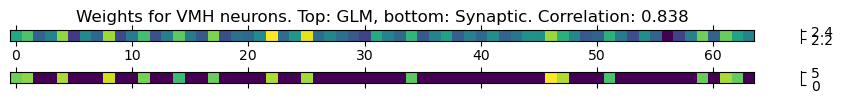

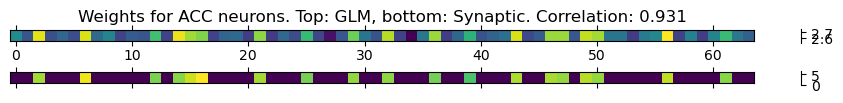

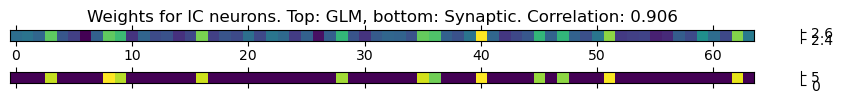

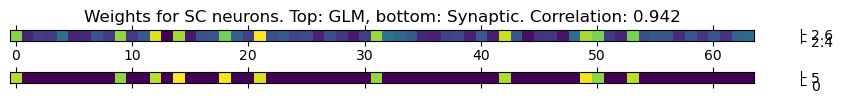

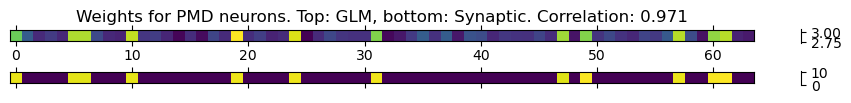

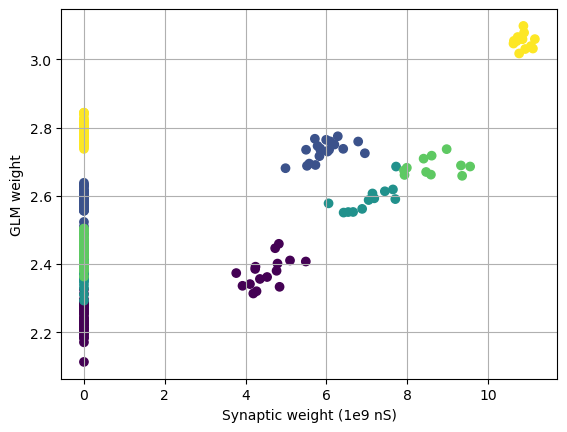

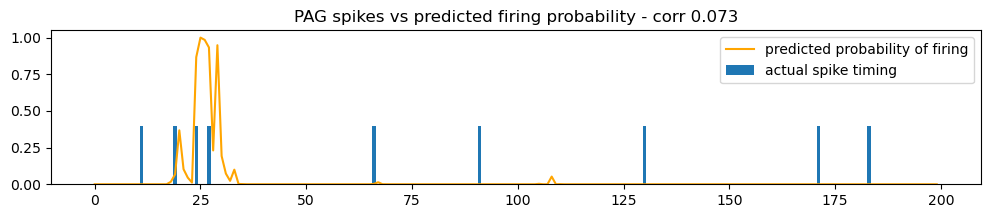

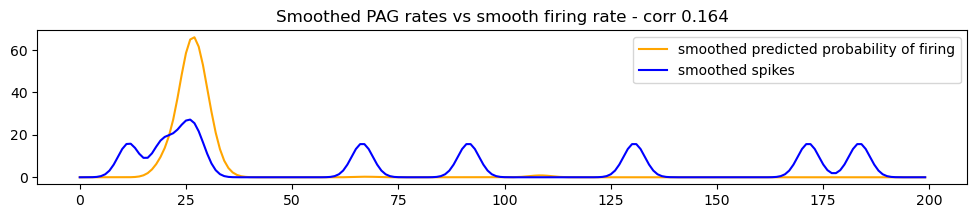

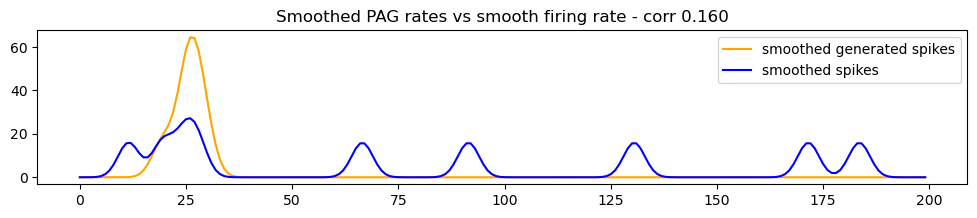

In [7]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

### Test 2.1 : Add regularisation term on beta
beta regularisation: 1 * beta**2 + n * beta ** (-3)

In [11]:
from glm import BernoulliGLMBetaRegPyTorch

glm = BernoulliGLMBetaRegPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    weights_reg_params=1,
    beta_reg_params=np.array([1,1,3,2]),
    ).to(device)

glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg1_betareg=2,3.pth'))

glm.fit(X_train.T, y_train.T, n_iter=10000, lr=1e-3, verbose=1, decay=0.9999)
glm.load_best_params()
torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg1_betareg=2,3.pth')

2023-12-11 18:35:45.622 | DEBUG    | glm:fit:294 - Training GLM with PyTorch. Initial log like: -45635.953125, inital loss: [[45905.78]]
2023-12-11 18:35:51.644 | DEBUG    | glm:fit:317 - Step 500. Log like: -45506.3203125,  loss: 45741.9453125
2023-12-11 18:35:57.569 | DEBUG    | glm:fit:317 - Step 1000. Log like: -45418.00390625,  loss: 45619.078125
2023-12-11 18:36:03.339 | DEBUG    | glm:fit:317 - Step 1500. Log like: -45360.7578125,  loss: 45529.41015625
2023-12-11 18:36:09.455 | DEBUG    | glm:fit:317 - Step 2000. Log like: -45324.68359375,  loss: 45464.2890625
2023-12-11 18:36:15.236 | DEBUG    | glm:fit:317 - Step 2500. Log like: -45302.75,  loss: 45417.68359375
2023-12-11 18:36:20.966 | DEBUG    | glm:fit:317 - Step 3000. Log like: -45290.01171875,  loss: 45385.2890625
2023-12-11 18:36:26.873 | DEBUG    | glm:fit:317 - Step 3500. Log like: -45282.98828125,  loss: 45363.86328125
2023-12-11 18:36:32.884 | DEBUG    | glm:fit:317 - Step 4000. Log like: -45279.296875,  loss: 45350.

KeyboardInterrupt: 

In [12]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [-7.7723002]
y-intercept: [0.00042107]


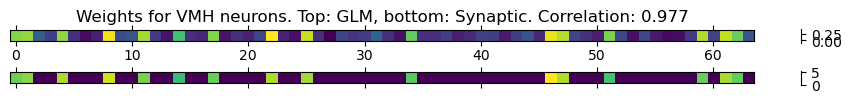

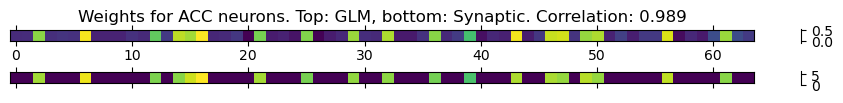

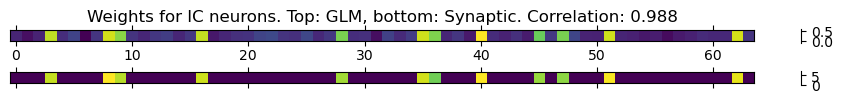

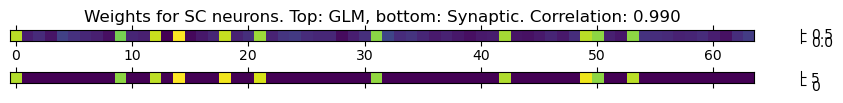

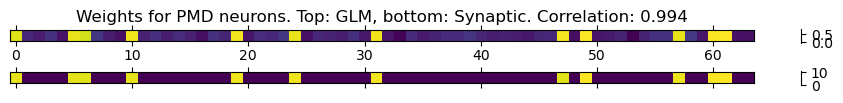

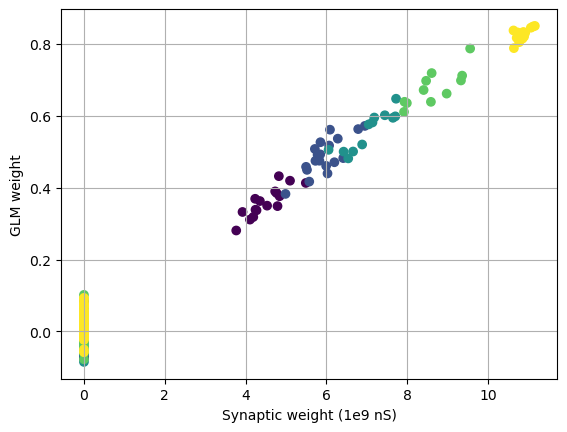

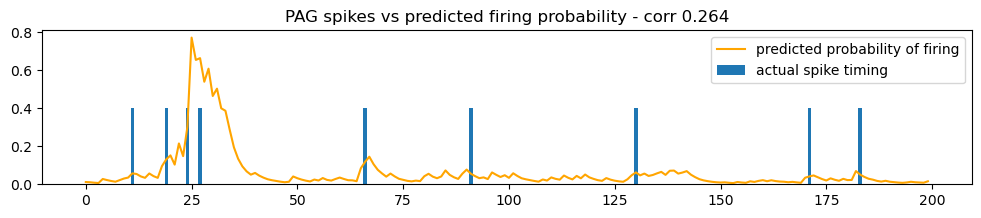

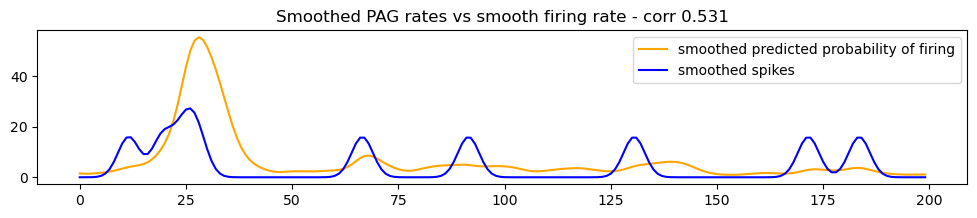

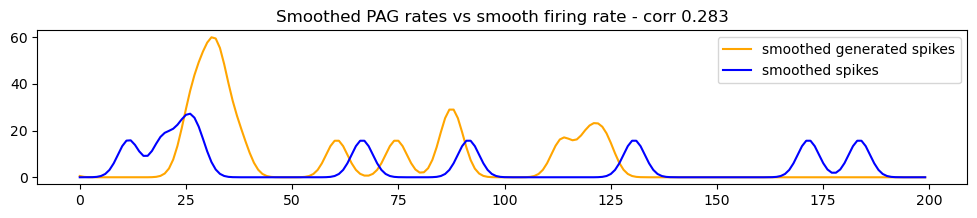

In [13]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

### Test 2.2 : Add regularisation term on beta
beta regularisation: 1 * beta**4 + n * beta ** (-5)

In [7]:
from glm import BernoulliGLMBetaRegPyTorch

glm = BernoulliGLMBetaRegPyTorch(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    weights_reg_params=1,
    beta_reg_params=np.array([1,1,5,4]),
    ).to(device)

# glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg1_betareg=4,5.pth'))

glm.fit(X_train.T, y_train.T, n_iter=30000, lr=1e-3, verbose=1, decay=0.9999)
glm.load_best_params()
torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg1_betareg=4,5.pth')

2023-12-11 19:01:45.592 | DEBUG    | glm:fit:283 - Training GLM with PyTorch. Initial log like: -216980.40625, inital loss: [[13043874.]]
2023-12-11 19:02:03.453 | DEBUG    | glm:fit:306 - Step 1500. Log like: -53353.66015625,  loss: 54899.0703125


KeyboardInterrupt: 

In [16]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [-5.7177706]
y-intercept: [0.00327626]


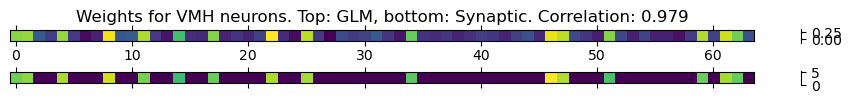

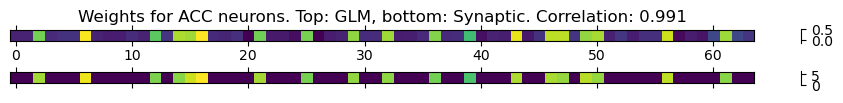

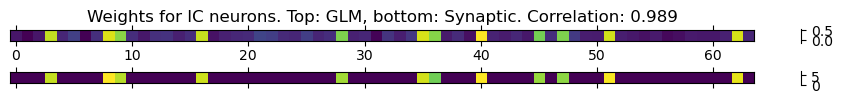

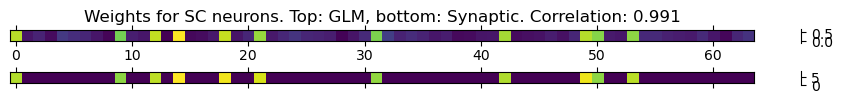

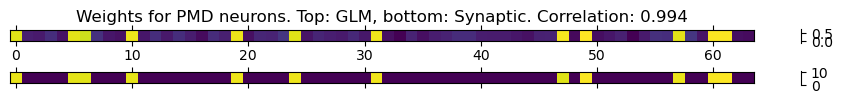

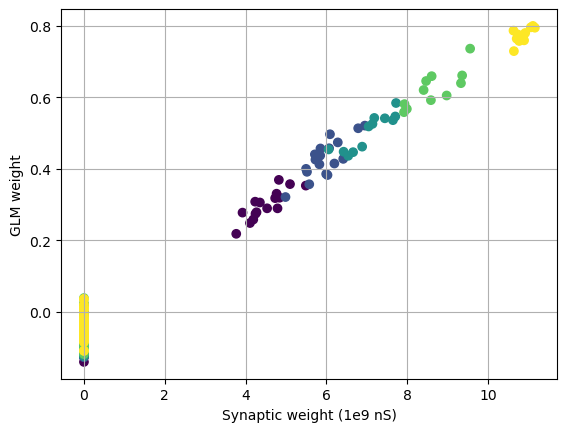

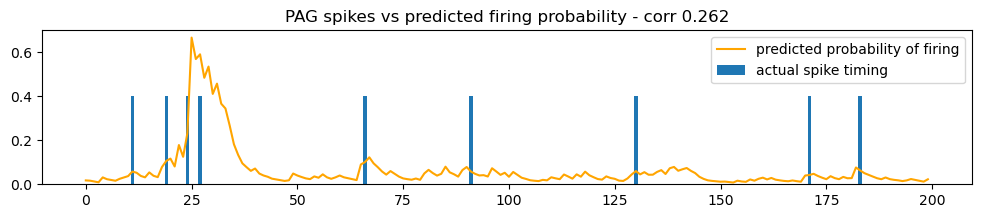

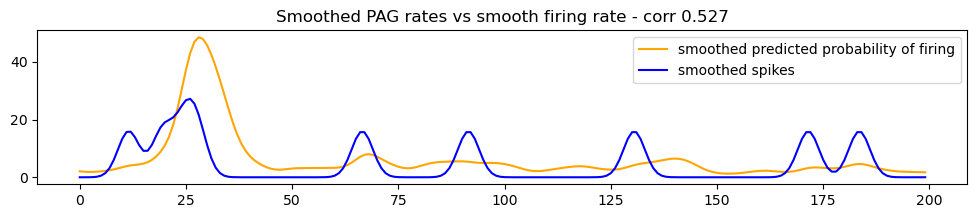

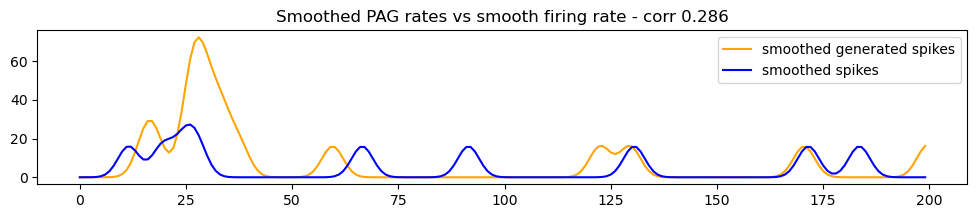

In [17]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

In [23]:
X_train.T.shape
X_train= torch.FloatTensor(X_train)

In [25]:
torch.vstack([X_train.T[1:,:], X_train.T[2:,:]]).shape

torch.Size([599997, 320])

In [77]:
X_train.shape

(320, 300000)

### Test 3: History filter

In [ ]:
glm = BernoulliGLMwHistoryPyTorch_(
    group_names=brain_regions,
    n_neurons_per_group=np.array([64, 64, 64, 64, 64]),
    link_fn='logistic',
    n_sessions=n_PAG_to_use,
    weights_reg_params=1,
    history=2,
    ).to(device)

# glm._load_state_dict(torch.load(f'{sim_data_path}sing_exp_reg1_betareg=4,5.pth'))

glm.fit(X_train.T, y_train.T, n_iter=100, lr=5*1e-3, verbose=2, decay=0.9999)
glm.load_best_params()
torch.save(glm.state_dict(), f'{sim_data_path}sing_exp_reg1_hist2.pth')

2023-12-12 17:23:03.853 | DEBUG    | glm:fit:284 - Training GLM with PyTorch. Initial log like: -183428.125, inital loss: 183428.03125
2023-12-12 17:31:23.594 | DEBUG    | glm:fit:304 - Step 1. Log like: -183427.96875,  loss: 183428.03125
2023-12-12 17:42:33.560 | DEBUG    | glm:fit:304 - Step 2. Log like: -164991.15625,  loss: 164991.21875
2023-12-12 17:53:58.423 | DEBUG    | glm:fit:304 - Step 3. Log like: -148528.09375,  loss: 148528.15625
2023-12-12 18:05:54.888 | DEBUG    | glm:fit:304 - Step 4. Log like: -133968.0625,  loss: 133968.140625
2023-12-12 18:17:44.271 | DEBUG    | glm:fit:304 - Step 5. Log like: -121214.671875,  loss: 121214.7421875
2023-12-12 18:29:35.850 | DEBUG    | glm:fit:304 - Step 6. Log like: -110150.5546875,  loss: 110150.640625
2023-12-12 18:41:06.709 | DEBUG    | glm:fit:304 - Step 7. Log like: -100642.921875,  loss: 100643.0234375
2023-12-12 18:52:50.180 | DEBUG    | glm:fit:304 - Step 8. Log like: -92549.2578125,  loss: 92549.359375
2023-12-12 19:04:29.476

In [ ]:
class BernoulliGLMwHistoryPyTorch_(BernoulliGLMPyTorch):
    def __init__(self,
                 group_names,
                 n_neurons_per_group=None,
                 synapse_origin_group=None,
                 link_fn='logistic',
                 n_sessions=1,
                 weights_reg_params=0,
                 history=1):
        
        super().__init__(group_names,
                         n_neurons_per_group=n_neurons_per_group,
                         synapse_origin_group=synapse_origin_group,
                         link_fn=link_fn,
                         n_sessions=n_sessions,
                         reg_params=weights_reg_params)
        
        assert isinstance(history, int) and history >= 1
        self.history = history
        self.history_filters = nn.Linear(self.history, 1, bias=False)
        self.spike_history = torch.zeros(1, self.history).to(device)
    
    def forward(self, X):
        '''
        Makes a forward prediction
        '''
        if isinstance(X, np.ndarray):
            X = torch.FloatTensor(X).to(device) # (bins, n_synapses)
        
        Y = torch.zeros(X.shape[0], 1).to(device)
        
        for step in range(X.shape[0]):
            Y[step,:] = self.activation(self.linear(X[step,:]) + self.history_filters(self.spike_history))
            
            self.spike_history = torch.hstack((Y[step,:][None,:], self.spike_history[:,:1]))
        return Y

In [80]:
glm_w, glm_b = glm.best_weight.cpu().numpy(), glm.best_bias.cpu().numpy() # shape (1, 320), (1,)
print('Learned bias:', glm_b)
print('y-intercept:', 1/(1+np.exp(-glm_b)))

Learned bias: [-0.06177839]
y-intercept: [0.48456028]


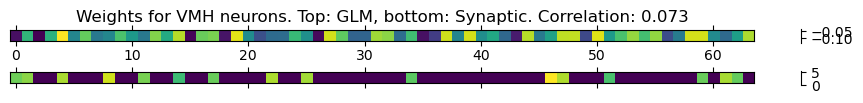

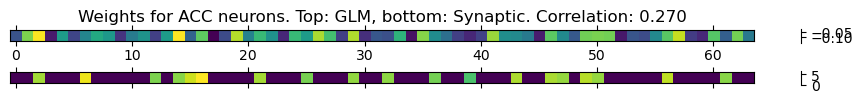

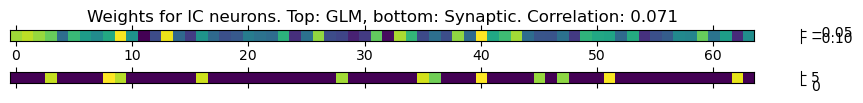

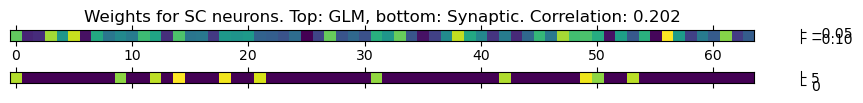

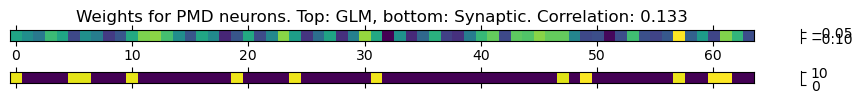

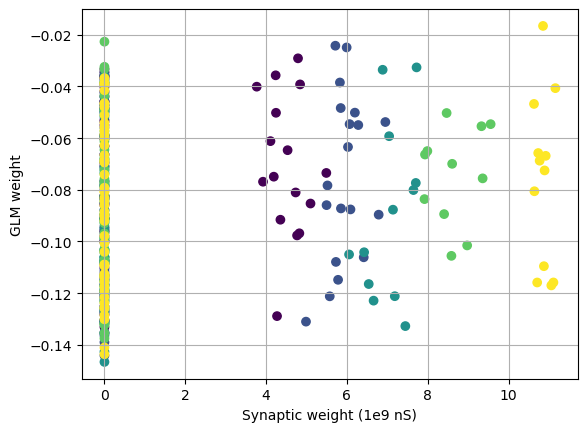

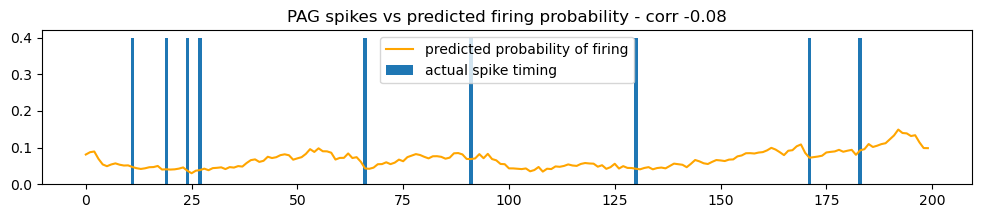

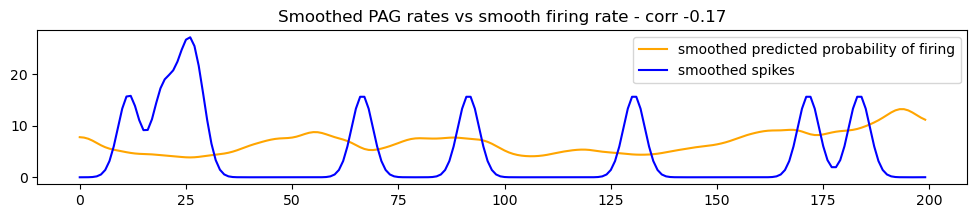

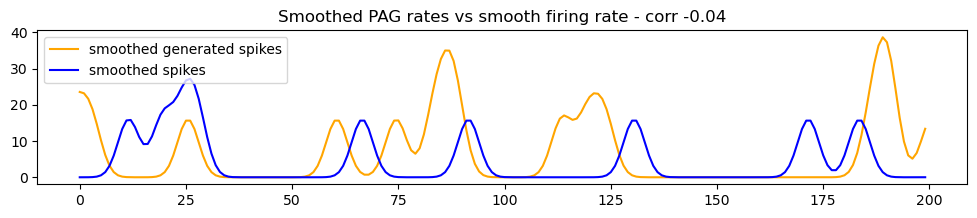

In [82]:
# comparison with actual connectivity
for m, brain_region in enumerate(brain_regions):
    
    corr = np.corrcoef(glm_w[..., glm.group_synapse_idx[m]], conns[m, :n_PAG_to_use, :])[0,1]
    f, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,1))
    mat1 = axes[0].matshow(glm_w[..., glm.group_synapse_idx[m]])
    f.colorbar(mat1, shrink=0.4)
    axes[0].set_title(f'Weights for {brain_region} neurons. Top: GLM, bottom: Synaptic. Correlation: {str(corr)[:5]}')
    axes[0].set_yticks([])

    mat2 = axes[1].matshow(conns[m, :n_PAG_to_use, :])
    f.colorbar(mat2, shrink=0.4)
    axes[1].set_yticks([])
plt.show()

# scatter plot of all learned weights
plt.scatter(conns[:,:n_PAG_to_use,:].flatten(), glm_w, c=glm.synapse_origin_group)
plt.xlabel('Synaptic weight (1e9 nS)')
plt.ylabel('GLM weight')
plt.grid()
plt.show()

# test set prediction
with torch.no_grad():
    y_test_hat = glm(X_test.T).T # (1 PAG neuron * 100 secs)
    

plt.figure(figsize=(12,2))
plt.plot(y_test_hat.cpu()[0,_random_start:_random_start + _range], label='predicted probability of firing', color='orange')
plt.bar(np.arange(_range), y_test[0,_random_start:_random_start + _range]*0.4, label='actual spike timing')
plt.legend()
plt.title(f'PAG spikes vs predicted firing probability - corr {str(np.corrcoef(y_test, y_test_hat.cpu())[0,1])[:5]}')
plt.show()

generated_spikes = generate_bernoulli_spikes(y_test_hat)

smooth_y_test = rbf_rate_convolution_1d(y_test[0], sigma=0.025, dt=0.01)                                        # smooth test set spikes
smooth_y_test_hat = rbf_rate_convolution_1d(y_test_hat[0].cpu(), sigma=0.025, dt=0.01)                          # smooth predicted probabilities
smooth_y_test_hat_generated_spikes = rbf_rate_convolution_1d(generated_spikes[0].cpu(), sigma=0.025, dt=0.01)   # smooth generated spikes

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat[_random_start:_random_start + _range], label='smoothed predicted probability of firing', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat, smooth_y_test)[0,1])[:5]}')
plt.show()

plt.figure(figsize=(12,2))
plt.plot(smooth_y_test_hat_generated_spikes[_random_start:_random_start + _range], label='smoothed generated spikes', color='orange')
plt.plot(smooth_y_test[_random_start:_random_start + _range], label='smoothed spikes', color='blue')
plt.legend()
plt.title(f'Smoothed PAG rates vs smooth firing rate - corr {str(np.corrcoef(smooth_y_test_hat_generated_spikes, smooth_y_test)[0,1])[:5]}')
plt.show()

In [ ]:
plt.hist(glm.history_filters.weight.data.cpu()[:320])

(array([20., 52., 72., 72., 29., 14., 17., 11., 20., 13.]),
 array([-0.19932969, -0.12045809, -0.0415865 ,  0.0372851 ,  0.1161567 ,
         0.19502831,  0.27389988,  0.35277149,  0.4316431 ,  0.51051468,
         0.58938628]),
 <BarContainer object of 10 artists>)

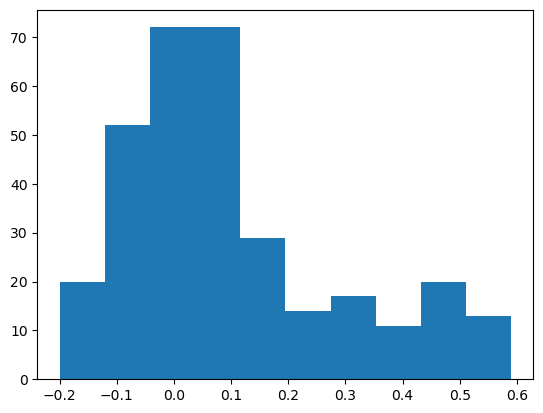

In [46]:
plt.hist(glm_w.T)